In [1]:
import os
import sys
from pathlib import Path

mod_path = os.path.join(Path.cwd().parent.parent)
if mod_path not in sys.path:
    sys.path.append(mod_path)

In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy

from typing import List, Tuple
from sklearn.model_selection import StratifiedKFold

from src.data import *
from src.features.utils import *
from src.model.tree_based import ModelXgBoost

In [3]:
# data with shape 28007, 33 [transaction related features]
train = pd.read_csv('../../data/processed/train.csv')
test_set = pd.read_csv('../../data/processed/test.csv')

In [4]:
train.drop(columns = 'Unnamed: 0', inplace=True)
test_set.drop(columns = 'Unnamed: 0', inplace=True)
# test_set.columns

In [5]:
train.shape

(28007, 35)

In [6]:
# Region has certain NaN values which might cause issues while encoding
# As total NaNs constitute ~5% of the data (1446) we remove it as of now
print(train['Region'].isna().sum() / train.shape[0] * 100)
train.dropna(subset=['Region'], how='all', inplace=True)

5.162994965544328


In [6]:
# Region has certain NaN values which might cause issues while encoding
# As total NaNs constitute ~5% of the data (1446) we remove it as of now
print(test_set['Region'].isna().sum() / test_set.shape[0] * 100)
# train.dropna(subset=['Region'], how='all', inplace=True)

# When attempting drop=first in OHE, the reverse transform throws an issue as it reads the NaN values as a separate
# category. So converting NaNs into strings
train['Region'] = train['Region'].fillna('Null')
test_set['Region'] = test_set['Region'].fillna('Null')

5.227077977720651


## Approach 2

s = pd.DataFrame(np.arange(0, len(train)), columns=['m1'])
df = train[['b1', 'b2', 'b3', 'b4', 'b5']]
df.drop(columns=['b5'], inplace=True)
df.rename(columns={'b1': 'b2', 'b2':'b3', 'b3': 'b4', 'b4': 'b5'}, inplace=True)
df.insert(loc=0, column='b1', value=s.values)
df

t = pd.DataFrame([[1]], columns=['a'])
q = pd.DataFrame([[1]], columns=['b'])
r = pd.DataFrame([['aum']], columns=['name'])

k = pd.concat([t, q])
kk = pd.merge(k, r, how='left', left_index=True, right_index=True)
kk

In [7]:
def slide_variable_window(
    predictor_array: pd.DataFrame,
    var_to_add: pd.DataFrame
) -> pd.DataFrame:
    predictor_array.drop(columns=['b5'], inplace=True)  # We drop the first payment
    predictor_array.rename(columns={'b1': 'b2', 'b2':'b3', 'b3': 'b4', 'b4': 'b5'}, inplace=True)
    predictor_array.insert(loc=0, column='b1', value=var_to_add.values)  # And add the new variable (mn)
    
    return predictor_array

In [8]:
# split_payment_history_df = train[["ID", "SplitPaymentsHistory"]]
# id_arr = train[["ID"]]

target = train[['m1', 'm2', 'm3', 'm4', 'm5', 'm6']]
train_arr = train.drop(columns=['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 
                                'SplitPaymentsHistory',
                                'ExpectedTermDate', 
                                'FirstPaymentDate',
                                'LastPaymentDate'])
test_set.drop(columns=['SplitPaymentsHistory',
                       'ExpectedTermDate', 
                       'FirstPaymentDate',
                       'LastPaymentDate'], inplace=True)

In [9]:
def create_data_with_sliding_approach(data_without_target: pd.DataFrame,
                                      target_data: pd.DataFrame):
    frame = pd.DataFrame(None)
    new_df = deepcopy(data_without_target)
    target_df = pd.DataFrame(None)
    target_features = target_data.columns.tolist()
    for itr, col in enumerate(target_features):
        if itr == 0:
            target_df = pd.concat([target_df, target_data[[col]]])
            frame = pd.concat([frame, data_without_target])
        else:
            filter_df = new_df[['b1', 'b2', 'b3', 'b4', 'b5']]  # Intermediate df
            new_df.drop(columns=['b1', 'b2', 'b3', 'b4', 'b5'], inplace=True)
            concatinating_df = slide_variable_window(predictor_array=filter_df, 
                                                     var_to_add=target_data[[target_features[itr-1]]])
            new_df = pd.concat([new_df, concatinating_df], axis=1)  # We add the newly created columns
            target_df = pd.concat([target_df, target_data[[col]]])
            frame = pd.concat([frame, new_df])
#             print(new_df.shape)

    target_df = pd.DataFrame(target_df.sum(axis=1).astype(int), columns=['target'])
#     print(frame.shape)  # Should be 6 * original data's no. of rows
    
    frame.reset_index(drop=True, inplace=True)
    target_df.reset_index(drop=True, inplace=True)
    
    return frame, target_df

In [10]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

seed = 10
X_train, X_test, y_train, y_test = train_test_split(train_arr, target, test_size=0.45, random_state=seed)

In [11]:
# X_train

### Model train on initial hp :: Approach 2

def approach_two_model(x_train, y_train, x_test):
    model = ModelXgBoost(train_array=x_train, train_target=y_train)
    model.train_model()  # Default h.params (Checkout the code)
    predict = model.trained_model.predict(x_test)
    
    return model, predict

In [12]:
def encode_and_drop(full_array, data_type, tr_encoder=None):
#     print(tr_encoder)
    categorical_array = full_array[full_array.select_dtypes(exclude=['number']).columns]
    numerical_array = full_array.drop(columns=full_array.select_dtypes(exclude=['number']).columns)
#     print(categorical_array.columns)
    encoded_array, encoder = one_hot_encoding(
        categorical_frame=categorical_array, 
        type_of_data=data_type,
        fitted_encoder=tr_encoder,
        conv=True,
        drop='first',
        handle_unknown="error"
    )
#     print(encoded_array.columns)
    final_array = pd.concat([numerical_array.reset_index(drop=True), 
                             encoded_array.reset_index(drop=True)], axis=1)
    final_array.index = numerical_array.index
#     print(final_array.shape)
    return numerical_array, encoded_array, encoder

In [43]:
def get_top_features(
    features,
    feature_scores,
    cut_off_score=0.8
) -> Tuple[List[List], List[List]]:
    frame = pd.DataFrame([feature_scores], columns=features, index=['gain']).T
    frame.sort_values(by=['gain'], ascending=False, inplace=True)
    frame['cum_gain'] = frame['gain'].cumsum()
    
    feature_list = list(frame[frame['cum_gain'] <= cut_off_score].index)
    feature_scores_list = frame[frame['cum_gain'] <= cut_off_score]['gain'].tolist()
    
    return feature_list, feature_scores_list

In [45]:
def get_important_feature_scores(
    feature_corpus: List[List],
    score_corpus: List[List]
) -> pd.DataFrame:
    imp_column = dict()
    imp_col = dict()
    for feature_list, score_list in zip(feature_corpus, score_corpus):
        for feature_names, scores in zip(feature_list, score_list):
            if feature_names not in imp_column.keys():
                imp_column[feature_names] = 1
#                 imp_col[feature_names] = [scores]
            else:
                imp_column[feature_names] += 1
#                 imp_col[feature_names].append(scores)
    
    important_features_df = pd.DataFrame(imp_column, index=['frequency']).T
#     important_scores = pd.DataFrame(imp_col)
    important_features_df['appearance_ratio'] = important_features_df['frequency'] / 100
    important_features_df.sort_values(by=['frequency'], ascending=False, inplace=True)
#     important_features_df['cum_score'] = important_features_df['score'].cumsum()
    
    return important_features_df

In [46]:
# Preparing the TRAIN data for approach two and fitting the model
train_data, target_frame = create_data_with_sliding_approach(data_without_target=X_train, 
                                                             target_data=y_train)
id_array = train_data[["ID"]]
train_data.drop(columns=["ID"], inplace=True)
og_frame, encoded_train, encoder_model = encode_and_drop(train_data, "train", None)

# encoded_train = pd.concat([encoded_train, train_data[['b1', 'b2', 'b3', 'b4', 'b5']]], axis=1)
print(encoded_train.shape)

np.random.seed(0)
r = np.random.randint(1, 100, 100)
f_i_list = []
f_i_features = []
for i, _seed in enumerate(r):
    sample= encoded_train.sample(n=20000, replace=False, random_state=_seed)
    target_f = target_frame[target_frame.index.isin(sample.index)]
    model_two_obj = ModelXgBoost(train_array=sample, 
                                 train_target=target_f)
    model_two_obj.train_model()  # Default h.params (Checkout the code)
    model_two = model_two_obj.trained_model
    f_i = model_two.feature_importances_
    f_i_cols = sample.columns
    variables, variable_scores = get_top_features(features=f_i_cols, feature_scores=f_i, cut_off_score=0.8)
    f_i_list.append(variable_scores)
    f_i_features.append(variables)

important_features_df = get_important_feature_scores(feature_corpus=f_i_features, score_corpus=f_i_list)

/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


(87648, 39)


In [47]:
important_features_df

,frequency,appearance_ratio
Age,99,0.99
b1,98,0.98
b2,87,0.87
amount_paid,81,0.81
stddev_amt_paid,78,0.78
mean_amt_paid,75,0.75
b3,73,0.73
b4,69,0.69
b5,65,0.65
percent_amt_paid,56,0.56


In [31]:
og_frame, encoded_train, encoder_model = encode_and_drop(train_data, "train", None)


Index(['DAILY', 'MONTHLY', 'WEEKLY', 'Female', 'Male', 'Coast Region',
       'Mount Kenya Region', 'Nairobi Region', 'North Rift', 'Nyanza',
       'South Rift', 'Western', 'Business', 'Driver/Motorbike Rider', 'Farmer',
       'Government Employee', 'Labourer', 'Other', 'Teacher'],
      dtype='object')


In [48]:
# important_features_df.to_csv('../../submissions/important_features_total_gain_with_80_cutoff.csv')

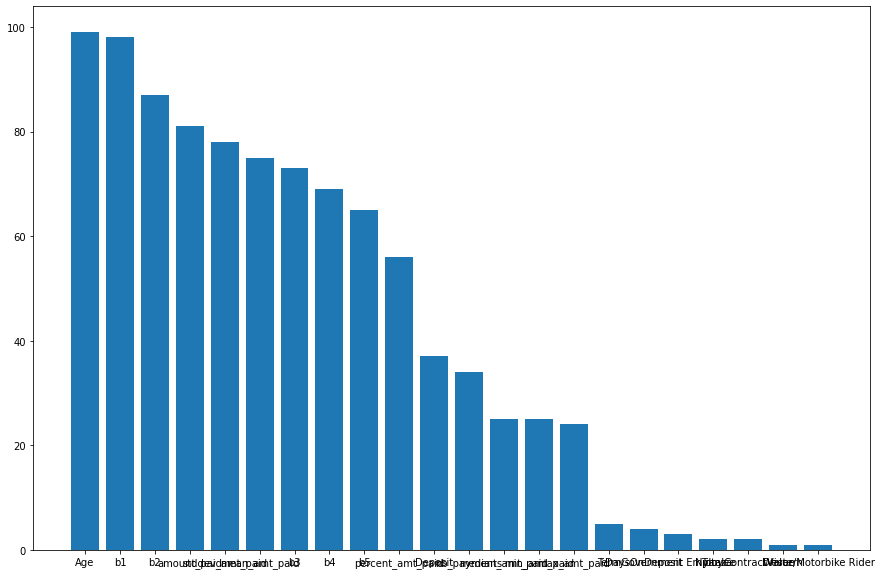

In [49]:
from matplotlib import pyplot

pyplot.figure(figsize=(15,10))
pyplot.bar(important_features_df.index, important_features_df['frequency'])
# xgb.plot_importance(model_two)
pyplot.show()

In [20]:
# feature_selection = list(important_features_df[important_features_df['cum_score'] <= 0.8].index)
feature_selection = [
    'b1',
    'Business',
    'Labourer',
    'TotalContractValue',
    'Western',
    'Mount Kenya Region',
    'Female',
    'Coast Region',
    'Nyanza',
    'Farmer',
    'Other',
    'South Rift',
    'stddev_amt_paid',
    'Teacher',
    'Nairobi Region',
    'DaysOnDeposit',
    'min_amt_paid',
    'Term',
    'b4',
    'mean_amt_paid',
    'b2',
    'Age',
    'amount_paid',
    'nb_payments',
    'median_amt_paid',
    'max_amt_paid',
    'Deposit',
    'b3',
    'percent_amt_paid',
    'b5'
]


In [13]:
# Preparing the TRAIN data for approach two and fitting the model
train_data, target_frame = create_data_with_sliding_approach(data_without_target=X_train, 
                                                             target_data=y_train)
id_array = train_data[["ID"]]
train_data.drop(columns=["ID"], inplace=True)
og_frame, encoded_train, encoder_model = encode_and_drop(train_data, "train", None)
# encoded_train = encoded_train[feature_selection]
encoded_train = pd.concat([encoded_train, train_data[['b1', 'b2', 'b3', 'b4', 'b5']]], axis=1)
# print(encoded_train.shape)

model_two_obj = ModelXgBoost(train_array=encoded_train,
                             train_target=target_frame)
model_two_obj.train_model()  # Default h.params (Checkout the code)
model_two = model_two_obj.trained_model


/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Prediction using Model :: Approach 2

In [14]:
test_id_array = X_test[["ID"]]
X_test.drop(columns=["ID"], inplace=True)

/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
# Encoding and re-attaching using train encoding model
og_frame_test, encoded_test, encoder_model = encode_and_drop(X_test, "test", encoder_model)
encoded_test = pd.concat([encoded_test, X_test[['b1', 'b2', 'b3', 'b4', 'b5']].reset_index(drop=True)], axis=1)

predict_dict = dict()
# encoded_test = encoded_test[feature_selection]
for col_no, predict_col in enumerate(y_test.columns):
    predict_dict[f"m{col_no+1}_pred"] = model_two.predict(encoded_test)
    int_df = encoded_test[['b1', 'b2', 'b3', 'b4', 'b5']]
    encoded_test.drop(columns=['b1', 'b2', 'b3', 'b4', 'b5'], inplace=True)
    concatinating_df = slide_variable_window(predictor_array=int_df, 
                                             var_to_add=pd.DataFrame(predict_dict[f"m{col_no+1}_pred"]))
    encoded_test = pd.concat([encoded_test, concatinating_df], axis=1)  # We add the newly created columns
    
predict_dict

/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


{'m1_pred': array([1312.5391 ,  724.73895,   75.12879, ..., 1530.3356 , 1458.8456 ,
        1198.9733 ], dtype=float32),
 'm2_pred': array([1294.2546  ,  679.0865  ,  111.778114, ..., 1468.2092  ,
        1381.8628  , 1022.49854 ], dtype=float32),
 'm3_pred': array([1196.0316 ,  687.7618 ,  105.51476, ..., 1437.452  , 1333.7384 ,
         899.16205], dtype=float32),
 'm4_pred': array([1116.6182 ,  661.09955,  130.85216, ..., 1399.297  , 1332.8679 ,
         714.56696], dtype=float32),
 'm5_pred': array([1033.0432,  626.6238,  145.245 , ..., 1327.018 , 1229.2456,
         668.316 ], dtype=float32),
 'm6_pred': array([1018.6896 ,  625.56354,  191.08568, ..., 1263.2454 , 1115.807  ,
         659.57086], dtype=float32)}

In [16]:
for k, v in predict_dict.items():
    predict_dict[k] = [0 if i < 0 else i for i in v]
    for _v in v:
        if _v < 0:
            print(_v)
# predict_dict

-307.70688
-115.81817
-2.2030687
-238.54391
-505.05783
-338.21112
-76.991646
-33.419613
-124.288864
-86.89496
-186.09164
-446.4476
-271.30228
-178.38742
-38.82201
-282.02374
-125.88486
-85.18992
-132.84639
-13.080331
-505.47446
-229.82645
-141.85376
-2309.8667
-89.62878
-482.87445
-2683.338
-70.400826
-695.3642
-264.89954
-9.703663
-115.495186
-73.09885
-564.45026
-14.2245865
-7.605969
-32.56536
-172.33122
-119.249825
-609.5148
-403.70853
-435.63293


In [ ]:
encoded_test.columns

### Calculation of RMSE

In [17]:
pred_frame = pd.DataFrame(predict_dict)
pred_frame.index = X_test.index

In [18]:
full_test_array = pd.concat([X_test, y_test, pred_frame], axis=1)

In [19]:
full_test_array = pd.merge(full_test_array, test_id_array, how='left', left_index=True, right_index=True)

In [20]:
sub_file = SubmissionFile(
    validation_data=full_test_array,
    type_of_data='validation'
).execute()

In [21]:
sub_file.shape

(75624, 3)

In [22]:
sub_file['SquaredError'] = np.square(sub_file['Target'] - sub_file['Prediction'])

In [23]:
rmse = np.sqrt(np.sum(sub_file['SquaredError'])/sub_file.shape[0])
print('Final RMSE --> ', rmse)

Final RMSE -->  874.6747856223318


### Preparing Submission

In [78]:
# Preparing the Entire TRAIN data for approach two and fitting the model
train_data, target_frame = create_data_with_sliding_approach(data_without_target=train_arr, 
                                                             target_data=target)
print(train_data.columns)
id_array = train_data[["ID"]]
train_data.drop(columns=["ID"], inplace=True)
og_frame, encoded_train, encoder_model = encode_and_drop(train_data, "train", None)
print(encoded_train.columns)
# encoded_train = encoded_train[feature_selection]
print(encoded_train.columns)
encoded_train = pd.concat([encoded_train, train_data[['b1', 'b2', 'b3', 'b4', 'b5']]], axis=1)

model_two_obj = ModelXgBoost(train_array=encoded_train, 
                             train_target=target_frame)
model_two_obj.train_model()  # Default h.params (Checkout the code)
model_two = model_two_obj.trained_model

Index(['ID', 'Deposit', 'AccessoryRate', 'rateTypeEntity', 'RatePerUnit',
       'DaysOnDeposit', 'MainApplicantGender', 'Age', 'Region', 'Occupation',
       'Term', 'TotalContractValue', 'nb_payments', 'amount_paid',
       'percent_amt_paid', 'mean_amt_paid', 'median_amt_paid', 'max_amt_paid',
       'min_amt_paid', 'stddev_amt_paid', 'b1', 'b2', 'b3', 'b4', 'b5'],
      dtype='object')
Index(['MONTHLY', 'WEEKLY', 'Male', 'Mount Kenya Region', 'Nairobi Region',
       'North Rift', 'Null', 'Nyanza', 'South Rift', 'Western',
       'Driver/Motorbike Rider', 'Farmer', 'Government Employee', 'Labourer',
       'Other', 'Teacher'],
      dtype='object')
Index(['MONTHLY', 'WEEKLY', 'Male', 'Mount Kenya Region', 'Nairobi Region',
       'North Rift', 'Null', 'Nyanza', 'South Rift', 'Western',
       'Driver/Motorbike Rider', 'Farmer', 'Government Employee', 'Labourer',
       'Other', 'Teacher'],
      dtype='object')


# Strategy to impute missing regions | did not work
most_common_region = test_set['Region'].value_counts().index[0]
test_set.loc[test_set['Region'].isna(), 'Region'] = most_common_region

In [79]:
test_id = test_set[["ID"]]
test_set.drop(columns=["ID"], inplace=True)

# Encoding and re-attaching using train encoding model
og_frame_test, encoded_test, encoder_model = encode_and_drop(test_set, "test", encoder_model)
# encoded_test = encoded_test[feature_selection]
encoded_test = pd.concat([encoded_test, test_set[['b1', 'b2', 'b3', 'b4', 'b5']].reset_index(drop=True)], axis=1)

predict_dict = dict()

for col_no, predict_col in enumerate(['m1', 'm2', 'm3', 'm4', 'm5', 'm6']):
    predict_dict[f"m{col_no+1}_pred"] = model_two.predict(encoded_test)
    int_df = encoded_test[['b1', 'b2', 'b3', 'b4', 'b5']]
    encoded_test.drop(columns=['b1', 'b2', 'b3', 'b4', 'b5'], inplace=True)
    concatinating_df = slide_variable_window(predictor_array=int_df, 
                                             var_to_add=pd.DataFrame(predict_dict[f"m{col_no+1}_pred"]))
    encoded_test = pd.concat([encoded_test, concatinating_df], axis=1)  # We add the newly created columns
    
# predict_dict

/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/aumaron/.local/share/virtualenvs/zindi_payg-FXkRANRI/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [80]:
for ke, va in predict_dict.items():
    # predict_dict[ke] = [0 if i < 0 else i for i in va]
    for _va in va:
        if _va < 0:
            print(_va)

-27.82334
-155.75896
-93.281136
-135.12369
-86.5752
-3.7002027
-87.47784
-94.077965
-74.16988
-590.0807
-219.53244
-151.39647
-168.4362
-18.941334
-414.90723
-63.450375
-115.86874
-290.13742
-51.83174


In [81]:
pred_frame_test = pd.DataFrame(predict_dict)
pred_frame_test.index = test_set.index

In [82]:
full_test_array_test = pd.concat([test_set, pred_frame_test], axis=1)
full_test_array_test = pd.merge(full_test_array_test, test_id, how='left', left_index=True, right_index=True)

In [83]:
sub_file = SubmissionFile(
    validation_data=full_test_array_test,
    type_of_data='test'
).execute()
sub_file.reset_index(drop=True, inplace=True)

In [84]:
sub_file.to_csv('../../submissions/submission_approach_2_null_region_category.csv')

In [85]:
sub_file

,ID,Target
0,ID_000RHRU x m1,201.791641
1,ID_000RHRU x m2,224.120941
2,ID_000RHRU x m3,225.497955
3,ID_000RHRU x m4,261.980835
4,ID_000RHRU x m5,276.416199
...,...,...
56011,ID_ZZOKWZJ x m2,913.030701
56012,ID_ZZOKWZJ x m3,874.852234
56013,ID_ZZOKWZJ x m4,816.791687
56014,ID_ZZOKWZJ x m5,823.228455
